Miftahul Huda \\
miftahul@student.itera.ac.id

# Prepare Datasets

The facial datasets is used as an object from kaggle and Pascal VOC 2007 as a non-object from roboflow

In [ ]:
import requests

url = 'https://raw.githubusercontent.com/Mfys212/dokumen/main/kaggle.json'
destination = '/content/kaggle.json'

response = requests.get(url)
if response.status_code == 200:
  with open(destination, 'wb') as file:
    file.write(response.content)
  print(f'Succes {destination}')
else:
  print(f'Failed: {response.status_code}')

Succes /content/kaggle.json


In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d chazzer/smiling-or-not-face-data
!unzip -q /content/smiling-or-not-face-data.zip

Dataset URL: https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data
License(s): CC0-1.0
 56% 10.0M/18.0M [00:00<00:00, 31.1MB/s]
100% 18.0M/18.0M [00:00<00:00, 44.9MB/s]


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="LOe9sWJ4WskO7PBuo6CK")
project = rf.workspace("modd2").project("pascal-voc-2007-bhjgf")
version = project.version(1)
dataset = version.download("multiclass")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.8
    Uninstalling idna-3.8:
      Successfully uninstalled idna-3.8
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pascal-Voc-2007-1 in multiclass:: 100%|██████████| 5015/5015 [00:03<00:00, 1620.65it/s]


# Library

In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression
from tqdm.notebook import tqdm
import os

# Histogram of Oriented Gradients (HOG) Feature Extraction

HOG is a feature descriptor used in computer vision and image processing that captures the distribution of gradient orientations in localized portions of an image. This approach is particularly useful for object detection tasks such as pedestrian detection and face recognition. \\

- Gradient Calculation: For each pixel in the grayscale image, compute the gradient in both horizontal and vertical directions. This is typically achieved using gradient operators like the Sobel operator. The gradient at a pixel $(x, y)$ is computed as: \\
$G_x(x, y) = I(x + 1, y) - I(x - 1, y)$ \\
$G_y(x, y) = I(x, y + 1) - I(x, y - 1)$ \\
where $I(x,y)$ represents the intensity of the image at pixel $(x,y)$. Here, $G_x$ and $G_y$ denote the gradients in the horizontal and vertical directions, respectively.
- Magnitude and Orientation: The magnitude $M(x,y)$ and orientation $θ(x,y)$ of the gradient at pixel $(x,y)$ are then computed as: \\
$M(x, y) = \sqrt{G_x(x, y)^2 + G_y(x, y)^2}$ \\
$\theta(x, y) = \arctan 2(G_y(x, y), G_x(x, y))$ \\
where $\arctan 2$ is the two-argument arctangent function that calculates the angle of the gradient.

- Cell Division: Divides the image into small rectangular areas called cells. In the example, the cells are $4\times4$ pixels. \\
- Histogram Construction: For each cell, construct a histogram of gradient orientations. The orientation bins are usually divided into 9 or 18 discrete bins covering a range of 0 to 180 degrees or 0 to 360 degrees. The magnitude of gradients in each cell is accumulated into these orientation bins.
For each cell, the histogram $H_{cell}$ is computed as: \\
$H_{\text{cell}}(k) = \sum_{(x, y) \in \text{cell}} M(x, y) \cdot w_k(\theta(x, y))$ \\
where $w_k(θ(x,y))$ is the weight assigned to the gradient orientation $θ(x,y)$ in bin $k$.

- Block Division: Group several adjacent cells into a larger rectangular region called a block. Common block sizes are $2\times2$ cells.
- Normalization: Normalize the histograms of the cells within each block to reduce the effect of changes in illumination and contrast. This step is crucial for making the HOG features invariant to lighting conditions. One common normalization method is: \\
$H_{\text{block}} = \frac{H_{\text{block}}}{\sqrt{H_{\text{block}}^2 + \epsilon^2}}
$ \\
where $H_{block}$ is the concatenated histogram of all cells in the block, and $ϵ$ is a small value $(1e-6)$ to avoid division by zero.
- Concatenate Histograms: After normalization, concatenate the histograms of all blocks to form a single feature vector for the entire image or image region.
- Feature Vector: This concatenated vector, which can be quite large, represents the HOG feature descriptor for the image. It captures the gradient distribution information over the image area and is used for subsequent classification or detection tasks.

In [ ]:
def extract_hog_features(image_resized, resize_dim=None):
    if resize_dim is not None:
        image_resized = cv2.resize(image_resized, resize_dim)

    if len(image_resized.shape) == 3 and image_resized.shape[2] == 3:
        image_resized = rgb2gray(image_resized)

    features, hog_image = hog(image_resized, orientations=9, pixels_per_cell=(4, 4),
                              cells_per_block=(2, 2), visualize=True)
    return features, hog_image

def extract_features_from_folders(object_folder_path, no_object_folder_path, num_samples=100, resize_dim=(64, 64)):
    features_list = []
    labels_list = []
    hog_img = []
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

    def get_image_files(folder_path, num_samples):
        all_files = os.listdir(folder_path)
        image_files = [f for f in all_files if os.path.splitext(f)[1].lower() in image_extensions]
        return image_files[:num_samples]

    object_images = get_image_files(object_folder_path, num_samples)
    for image_file in object_images:
        image_path = os.path.join(object_folder_path, image_file)
        image = cv2.imread(image_path)
        if image is not None:
            features, hog_ = extract_hog_features(image, resize_dim)
            features_list.append(features)
            labels_list.append(1)
            hog_img.append(hog_)

    no_object_images = get_image_files(no_object_folder_path, int(num_samples*1.5))
    for image_file in no_object_images:
        image_path = os.path.join(no_object_folder_path, image_file)
        image = cv2.imread(image_path)
        if image is not None:
            features, hog_ = extract_hog_features(image, resize_dim)
            features_list.append(features)
            labels_list.append(0)
            hog_img.append(hog_)

    return np.array(features_list), np.array(labels_list), np.array(hog_img)

object_folder = '/content/non_smile'
no_object_folder = '/content/Pascal-Voc-2007-1/train'

features, labels, hog_img = extract_features_from_folders(object_folder, no_object_folder, num_samples=500, resize_dim=(64, 64))

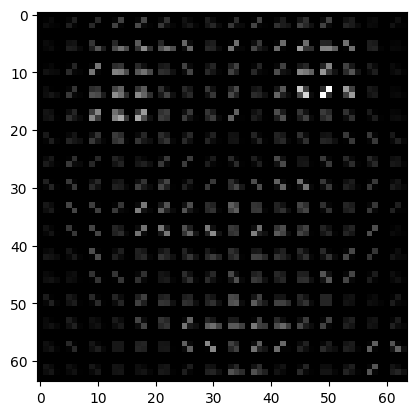

In [ ]:
plt.imshow(hog_img[100], cmap='gray')

# Training Support Vector Machine Classifier (Linear kernel for object classifier from HOG)

![](https://bytepawn.com/images/svm_1.png)

Why Linear kernel? \\
- HOG Features: HOG generates features that reflect gradient patterns in an image, which generally focus on edges and shapes. Since HOG describes local patterns in terms of gradient orientation histograms, the resulting features often have distributional properties that support linear separation. In many cases, HOG features are informative enough to allow good separation in the feature space with a linear hyperplane.

- HOG Data and Linear Kernel: In practice, HOG features extracted from object images are often high-dimensional but have a structure that is good enough to be linearly separable. This means that HOG is sufficient to provide a feature representation that supports linear separation of the two classes, so using a linear kernel can work very well without requiring additional non-linear transformations.

- Speed: SVMs with linear kernels are faster than non-linear kernels, such as Radial Basis Function (RBF) or polynomial kernels. Linear kernels only require a simple dot product calculation between feature vectors, while non-linear kernels require more complex calculations and often require more complex optimizations.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_train)
y_pred2 = svm.predict(X_test)
print(f'Train Accuracy: {accuracy_score(y_train, y_pred) * 100:.2f}%')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred2) * 100:.2f}%')

Train Accuracy: 100.00%
Test Accuracy: 99.20%


# Sliding Window

The sliding window technique is a method used to analyze or process data by applying a fixed-size window that moves across the dataset or signal. It involves positioning the window at various locations, performing a specific operation (such as averaging or feature extraction) within the window, and then shifting the window to the next position. This approach allows for localized analysis, making it useful in applications such as time series analysis, signal processing, and computer vision, where it helps manage and extract meaningful information from data in chunks.

![](https://www.researchgate.net/profile/Hafida-Benhidour/publication/345431594/figure/fig1/AS:955188156325889@1604746011536/An-illustration-of-the-sliding-window-technique.png)

In [ ]:
def sliding_window(image, window_size, step_size):
    """
    Generator untuk melakukan sliding window pada gambar.

    Args:
        image (np.array): Gambar input.
        window_size (tuple): Ukuran window (width, height).
        step_size (int): Jarak langkah sliding window.

    Yields:
        tuple: (x, y, window) - koordinat (x, y) dan sub-gambar window.
    """
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            window = image[y:y + window_size[1], x:x + window_size[0]]
            if window.shape[0] == window_size[1] and window.shape[1] == window_size[0]:
                yield (x, y, window)


# Non Maximum Suppression

![](https://wikidocs.net/images/page/163295/NMS_pseudocode.png)
![](https://kikaben.com/object-detection-non-maximum-suppression/images/nms-confidence-scores.png)

In [ ]:
def apply_nms(detected_windows, confidence_scores, overlap_thresh=0.3):
    """
    Menerapkan Non-Maximum Suppression (NMS) menggunakan bounding boxes dan confidence scores.

    Args:
        detected_windows (list): List dari bounding boxes (x, y, w, h).
        confidence_scores (list): Confidence score untuk setiap bounding box.
        overlap_thresh (float): Ambang batas overlap untuk NMS.

    Returns:
        np.array: Bounding boxes setelah diterapkan NMS.
    """
    if len(detected_windows) == 0:
        return []

    detected_windows = np.array(detected_windows)
    confidence_scores = np.array(confidence_scores)

    boxes = np.hstack([detected_windows[:, :2], detected_windows[:, :2] + detected_windows[:, 2:]])
    pick = non_max_suppression(boxes, probs=confidence_scores, overlapThresh=overlap_thresh)

    return pick

# Object Detection SVM+HOG

![](https://miro.medium.com/v2/resize:fit:1400/1*PoeiMz9K8fdtOF1A0eIViQ.png)

In [ ]:
def detect_objects(image, svm_model, window_size=(64, 64), step_size=8):
    detected_windows = []
    confidence_scores = []
    scales = np.linspace(0.1, 1.0, num=4)

    for scale in tqdm(scales, desc="Scaling Images", leave=False):
        resized_image = cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)))
        scale_factor = 1 / scale

        num_windows = ((resized_image.shape[0] - window_size[1]) // step_size) * ((resized_image.shape[1] - window_size[0]) // step_size)

        for (x, y, window) in tqdm(sliding_window(resized_image, window_size, step_size),
                                   total=num_windows, desc="Sliding Window", leave=False):
            features, _ = extract_hog_features(window)
            features = features.reshape(1, -1)

            pred = svm_model.predict(features)
            confidence = svm_model.predict_proba(features)[0][0]

            if pred == 1:
                x_original = int(x * scale_factor)
                y_original = int(y * scale_factor)
                w_original = int(window_size[0] * scale_factor)
                h_original = int(window_size[1] * scale_factor)

                detected_windows.append((x_original, y_original, w_original, h_original))
                confidence_scores.append(confidence)

    final_boxes = apply_nms(detected_windows, confidence_scores, overlap_thresh=0.0001)

    return final_boxes


def visualize_detection(image, detected, hog_image=None):
    if hog_image is None:
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Gambar Asli')

    axes[1].imshow(hog_image, cmap='gray')
    axes[1].set_title('HOG Image')

    image_with_bbox = image.copy()
    for (x, y, w, h) in detected:
        cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), (0, 255, 0), 3)

    axes[2].imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Deteksi Objek')

    for ax in axes:
        ax.axis('off')

    plt.show()

In [ ]:
!wget https://awsimages.detik.net.id/community/media/visual/2019/02/19/3fc2caf6-118c-457d-8a28-8868c1753fda.jpeg

--2024-09-16 16:39:43--  https://awsimages.detik.net.id/community/media/visual/2019/02/19/3fc2caf6-118c-457d-8a28-8868c1753fda.jpeg
Resolving awsimages.detik.net.id (awsimages.detik.net.id)... 203.190.242.102, 103.49.221.102
Connecting to awsimages.detik.net.id (awsimages.detik.net.id)|203.190.242.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6558 (6.4K) [image/jpeg]
Saving to: ‘3fc2caf6-118c-457d-8a28-8868c1753fda.jpeg’

3fc2caf6-118c-457d- 100%[===================>]   6.40K  --.-KB/s    in 0s      

2024-09-16 16:39:44 (101 MB/s) - ‘3fc2caf6-118c-457d-8a28-8868c1753fda.jpeg’ saved [6558/6558]



Scaling Images:   0%|          | 0/4 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/36 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/4 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/81 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/289 [00:00<?, ?it/s]

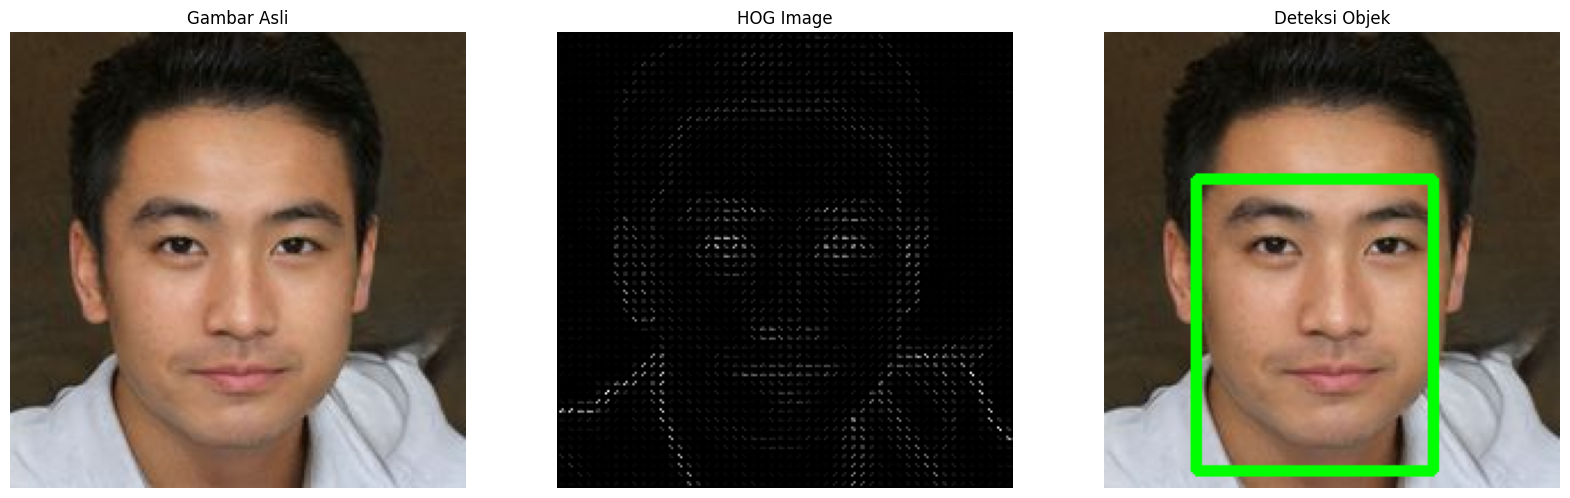

In [ ]:
test_image = cv2.imread("/content/3fc2caf6-118c-457d-8a28-8868c1753fda.jpeg")
detected = detect_objects(test_image, svm, window_size=(64, 64), step_size=8)
_, hog_ = extract_hog_features(test_image)
visualize_detection(test_image, detected, hog_)

In [ ]:
!wget https://static.promediateknologi.id/crop/0x0:0x0/0x0/webp/photo/indizone/2023/04/16/aPs8pZd/dian-sastro-foto-berdua-bareng-suami-sama-sama-senyum-kelihatan-gigi-mirip-gak15.jpg

--2024-09-16 17:43:36--  https://static.promediateknologi.id/crop/0x0:0x0/0x0/webp/photo/indizone/2023/04/16/aPs8pZd/dian-sastro-foto-berdua-bareng-suami-sama-sama-senyum-kelihatan-gigi-mirip-gak15.jpg
Resolving static.promediateknologi.id (static.promediateknologi.id)... 104.18.17.214, 104.18.16.214, 2606:4700::6812:11d6, ...
Connecting to static.promediateknologi.id (static.promediateknologi.id)|104.18.17.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70520 (69K) [image/webp]
Saving to: ‘dian-sastro-foto-berdua-bareng-suami-sama-sama-senyum-kelihatan-gigi-mirip-gak15.jpg’

dian-sastro-foto-be 100%[===================>]  68.87K  --.-KB/s    in 0.002s  

2024-09-16 17:43:36 (31.4 MB/s) - ‘dian-sastro-foto-berdua-bareng-suami-sama-sama-senyum-kelihatan-gigi-mirip-gak15.jpg’ saved [70520/70520]



Scaling Images:   0%|          | 0/4 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/4 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/1290 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/4779 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/10560 [00:00<?, ?it/s]

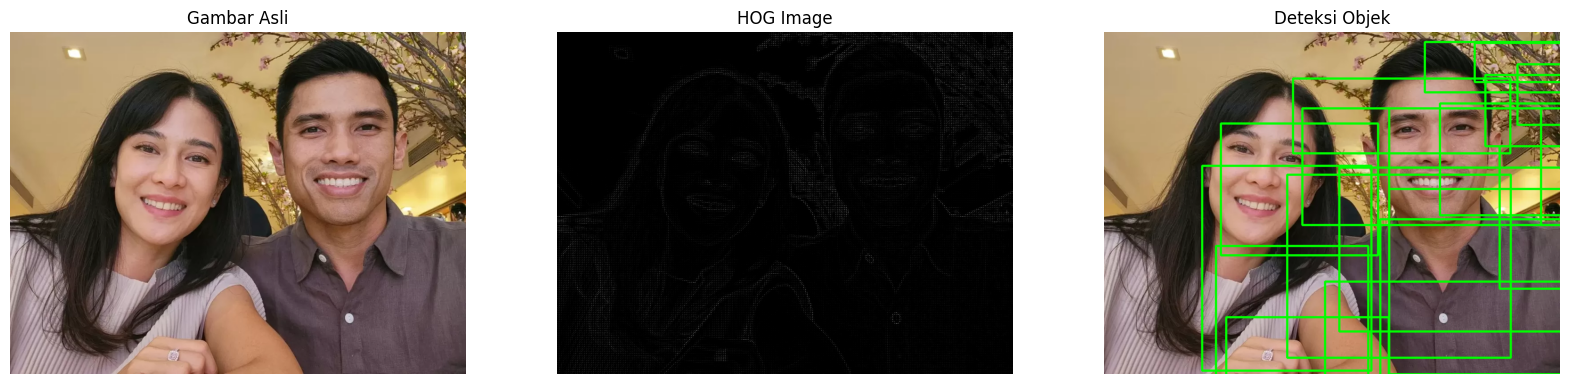

In [ ]:
test_image = cv2.imread("/content/dian-sastro-foto-berdua-bareng-suami-sama-sama-senyum-kelihatan-gigi-mirip-gak15.jpg")
detected = detect_objects(test_image, svm, window_size=(64, 64), step_size=8)
_, hog_ = extract_hog_features(test_image)
visualize_detection(test_image, detected, hog_)

In [ ]:
!wget https://portal.riau24.com/news/20200503/riau24_1588515284.jpg

--2024-09-16 18:11:05--  https://portal.riau24.com/news/20200503/riau24_1588515284.jpg
Resolving portal.riau24.com (portal.riau24.com)... 104.21.51.190, 172.67.184.39, 2606:4700:3033::ac43:b827, ...
Connecting to portal.riau24.com (portal.riau24.com)|104.21.51.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75389 (74K) [image/jpeg]
Saving to: ‘riau24_1588515284.jpg’

riau24_1588515284.j 100%[===================>]  73.62K  --.-KB/s    in 0.001s  

2024-09-16 18:11:07 (63.6 MB/s) - ‘riau24_1588515284.jpg’ saved [75389/75389]



Scaling Images:   0%|          | 0/4 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/1 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/440 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/1804 [00:00<?, ?it/s]

Sliding Window:   0%|          | 0/4154 [00:00<?, ?it/s]

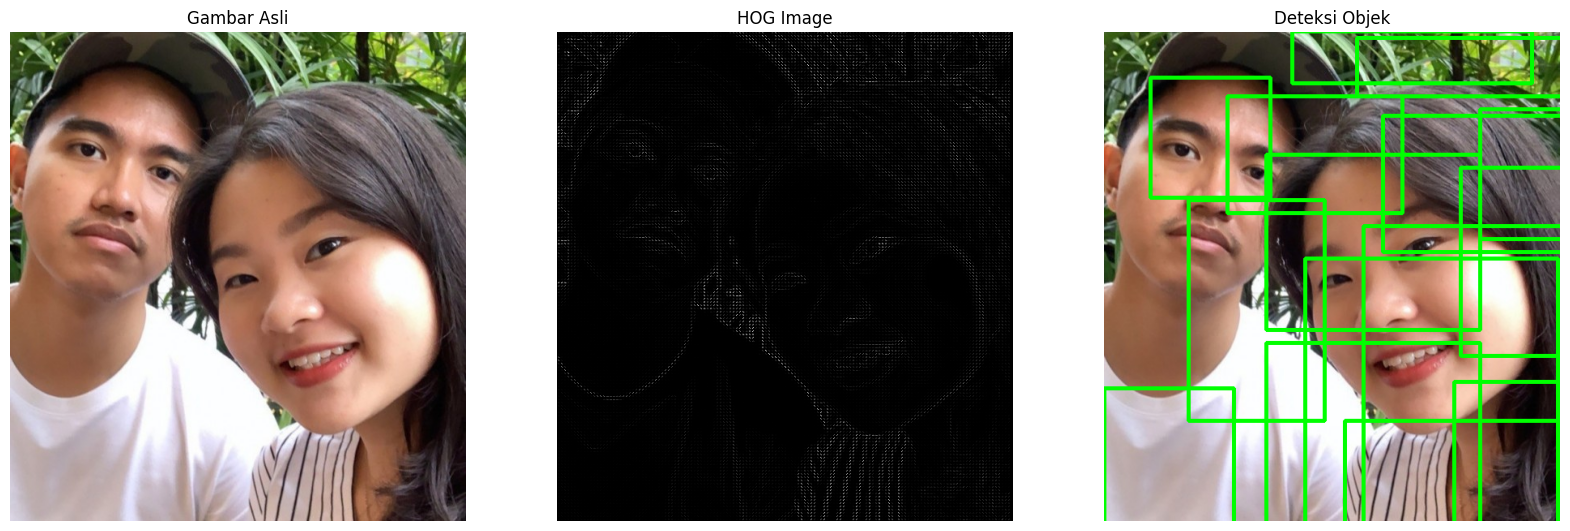

In [ ]:
test_image = cv2.imread("/content/riau24_1588515284.jpg")
detected = detect_objects(test_image, svm, window_size=(64, 64), step_size=8)
_, hog_ = extract_hog_features(test_image)
visualize_detection(test_image, detected, hog_)

# Results and Discussion

HOG is an edge-based feature detection method, where the image is broken down into small cells and orientation gradients are calculated to detect shape or structure. It is quite effective for objects that have strong and clear edges, such as the first experiment, for more complex objects such as the second and third experiments, or in poor lighting conditions or complex backgrounds, HOG is less effective in capturing feature variations. \\

HOG + SVM uses a template matching approach where the HOG features of an image are tested against a trained template. The SVM as a classifier then makes a decision whether the area contains an object or not. This means that this model is not flexible to changes in shape, pose, or scale of objects outside the scope of the training data. \\

HOG cannot easily handle large variations in the size, position, and orientation of objects. Although there are sliding window and image scaling mechanisms, it does not provide the flexibility of deep learning methods that can learn multi-scale and multi-pose representations from training data. \\

Currently, deep learning-based approaches are superior and popular in the case of object detection. \\

Why is Deep Learning More Popular for Object Detection? \\

Deep learning networks, especially Convolutional Neural Networks (CNN), automatically learn features from data end-to-end without the need to explicitly define features like HOGs. CNNs can recognize more complex patterns (edges, textures, shapes, colors) and are more robust to changes in lighting, backgrounds, and blurring of objects. \\

Deep learning models such as Faster R-CNN, YOLO (You Only Look Once), and SSD (Single Shot Multibox Detector) can detect objects at different scales, angles, and poses more accurately. These approaches can capture even small object details and provide more precise bounding boxes because they learn through hierarchical features from the image.